In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans.html
#!wget -nc http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans/floorplans16-01.zip
# !unzip -q -o -d data/ floorplans16-01.zip

DATA_DIR = 'data/'
print(os.listdir(DATA_DIR))

['data']


In [26]:
image_size = 256
batch_size = 128
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (1, 1, 1), (1, 1, 1)

transform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

train_ds = ImageFolder(DATA_DIR, transform = transform)

In [27]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [28]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1,2,0))

def show_batch(dl, nmax = 64)    :
    for images, _ in dl:
        show_images(images, nmax)
        break

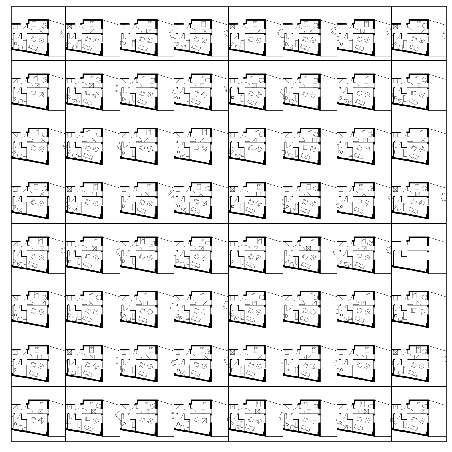

In [29]:
show_batch(train_dl)

In [30]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device  = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
        

In [31]:
device = get_default_device()
device

device(type='cpu')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)

In [33]:
discriminator = nn.Sequential(

    #in: 3 x image_size x image_size
    nn.Conv2d(3, image_size, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 64x32x32
    
    nn.Conv2d(image_size, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 128x16x16
    
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 256x8x8
    
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 512x4x4
    
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    #out: 1x1x1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [34]:
discriminator = to_device(discriminator, device)

In [36]:
latent_size = 256

In [37]:
generator = nn.Sequential(
    #in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out: 512x4x4
    
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out: 256x8x8
    
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128x16x16
    
    nn.ConvTranspose2d(128, image_size, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(image_size),
    nn.ReLU(True),
    #out: 64x32x32
    
    nn.ConvTranspose2d(image_size, 3, kernel_size = 4, stride = 2, padding =1, bias = False),
    nn.Tanh()
    #out: 3 x image_size x image_size
)

In [38]:
xb = torch.randn(batch_size, latent_size, 1, 1) #random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
# show_images(fake_images)

torch.Size([128, 3, 64, 64])


In [39]:
generator = to_device(generator, device)

In [40]:
def train_discriminator(real_images, opt_d):
    # clear grad
    opt_d.zero_grad()
    
    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # pass fake images through discriminator
    fake_targetes = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targetes)
    fake_score = torch.mean(fake_preds).item()
    
    # update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [41]:
def train_generator(opt_g):
    # clear generator gradients
    opt_g.zero_grad()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [42]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_filename = 'generated-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_filename), nrow = 8)
    # print("Saving ", fake_filename)
    if show:
        fig, ax = plt.subplots(figsize = (8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

In [43]:
fixed_latent = torch.randn(image_size, latent_size, 1, 1, device = device)

In [44]:
#save_samples(0, fixed_latent)

In [45]:
def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    
    # losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # create oprimizeres
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # train generator
            loss_g =  train_generator(opt_g)
            
            # record losses and scores
            
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            
            # pring losses and scores
            message_template = "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}"
            print(message_template.format(
                epoch + 1,
                epochs,
                loss_g,
                loss_d,
                real_score,
                fake_score
            ))
            
            save_samples(epoch+start_idx, fixed_latent, show = True)
            
    return losses_g, losses_d, real_scores, fake_scores

In [46]:
lr = 5e-5
epochs = 15

history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 105906176 bytes. Error code 12 (Cannot allocate memory)


['generated-0001.png', 'generated-0011.png', 'generated-0007.png', 'generated-0015.png', 'generated-0014.png', 'generated-0002.png', 'generated-0004.png', 'generated-0009.png', 'generated-0003.png', 'generated-0006.png', 'generated-0005.png', 'generated-0012.png', 'generated-0000.png', 'generated-0013.png', 'generated-0008.png', 'generated-0010.png']


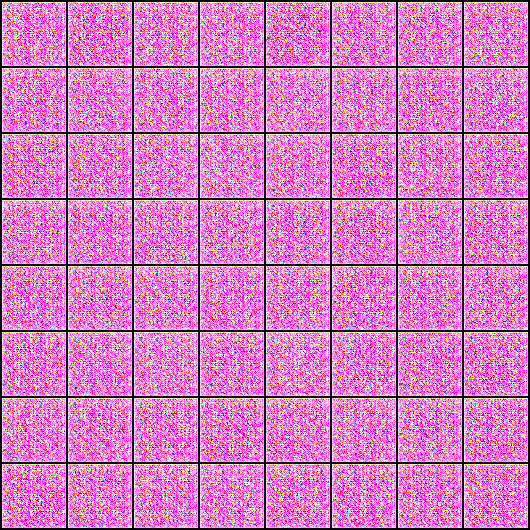

In [23]:
print(os.listdir('generated/'))
from IPython.display import Image
Image('generated/generated-{:04d}.png'.format(epochs))



Text(0.5, 1.0, 'Losses')

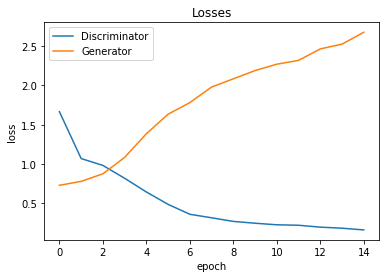

In [24]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt. legend(['Discriminator', 'Generator'])
plt.title('Losses')

/home/mk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'R' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/home/mk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/home/mk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/home/mk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'l' instances.
A prox

Text(0.5, 1.0, 'Scores')

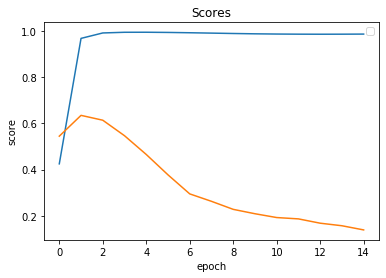

In [25]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend('Real', 'Fake')
plt.title('Scores')